## 1. Setup
Install dependencies and clone TensorFlow Object Detection API

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install ensemble-boxes==1.0.6

In [3]:
!pip install -U tf2onnx==1.8.5

     |████████████████████████████████| 370 kB 5.6 MB/s 
     |████████████████████████████████| 12.2 MB 9.5 MB/s 


In [4]:
!pip install nnoir-onnx==1.0.13

     |████████████████████████████████| 4.5 MB 9.6 MB/s 


In [5]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
!wget -q http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
!tar zxvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

--2021-07-20 01:00:23--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2021-07-20 01:00:23 (31.7 MB/s) - ‘coco-labels-paper.txt’ saved [702/702]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_2018_03_29/saved_model/variables/
ssd_mobilenet_v2_coco_2018_03_29/model

In [6]:
!git clone https://github.com/tensorflow/models.git
%cd models/
!git checkout 0ea84d6df6220552cd5229a0181c9e420f815408

Cloning into 'models'...
remote: Enumerating objects: 58940, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 58940 (delta 210), reused 278 (delta 157), pack-reused 58608
Receiving objects: 100% (58940/58940), 573.43 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (40898/40898), done.
/content/models
Note: checking out '0ea84d6df6220552cd5229a0181c9e420f815408'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 0ea84d6d Changing the default number of channels for lighter-weight hourglass backbones.


In [7]:
import os
import math
import subprocess
import onnx
import numpy as np
import tensorflow as tf
import cv2
import nnoir
from collections import namedtuple
from PIL import Image, ImageDraw, ImageFont
from ensemble_boxes import *

In [8]:
%cd /content/models/research 

/content/models/research


In [9]:
!apt --quiet update
!apt install --quiet protobuf-compiler

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa

In [10]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf1/setup.py .
!python3 -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 352 kB 5.3 MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1628539 sha256=f48c2d6186a20f90f0bb1753ee42c89c2d9f9e24015387024de1e03655e6c7bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-0dtfg56g/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
Successfully built object-detection


In [11]:
!python3 object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.7.11: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_w

## 2. Create TensorFlow Lite Model
- comment out batch_norm_trainable: true in pileline.config
- set add_postprocessing_op=False

In [12]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path="/content/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config" \
--trained_checkpoint_prefix="/content/ssd_mobilenet_v2_coco_2018_03_29/model.ckpt" \
--output_directory=/content \
--add_postprocessing_op=False

Instructions for updating:
Please use `layer.__call__` method instead.
W0720 01:02:19.451520 140113839368064 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0720 01:02:22.394907 140113839368064 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0720 01:02:22.435347 140113839368064 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0720 01:02:22.473583 140113839368064 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [13]:
!tflite_convert \
--graph_def_file=/content/tflite_graph.pb \
--output_file=/content/ssd_mobilenetv2.tflite \
--input_format=TENSORFLOW_GRAPHDEF \
--output_format=TFLITE \
--inference_type=FLOAT \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays=raw_outputs/box_encodings,raw_outputs/class_predictions

2021-07-20 01:02:30.284869: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-20 01:02:30.296411: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-20 01:02:30.296485: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4ee932196c4d): /proc/driver/nvidia/version does not exist
2021-07-20 01:02:30.302149: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-07-20 01:02:30.302412: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559c46d64a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-20 01:02:30.302447: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-20 01:02:30.807271: I tensorflow/core/grappler/de

## 3. Create anchor 
- https://qiita.com/PINTO/items/1312d308b553362a8ebf#%EF%BC%96appendix

In [14]:
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util

GRAPH_PB_PATH = '/content/tflite_graph.pb'

with tf.Session() as sess:
  with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    wts = [n for n in graph_nodes if n.op=='Const']
    for n in wts:
        if n.name == 'anchors':
            print("Name of the node - %s" % n.name)
            print("Value - ")
            anchors = tensor_util.MakeNdarray(n.attr['value'].tensor)
            print("anchors.shape =", anchors.shape)
            print(anchors)
            np.save('/content/anchors.npy', anchors)
            np.savetxt('/content/anchors.csv', anchors, delimiter=',')
            break

Instructions for updating:
Use tf.gfile.GFile.
Name of the node - anchors
Value - 
anchors.shape = (1917, 4)
[[0.02631579 0.02631579 0.1        0.1       ]
 [0.02631579 0.02631579 0.14142136 0.28284273]
 [0.02631579 0.02631579 0.28284273 0.14142136]
 ...
 [0.5        0.5        0.5484828  1.6454482 ]
 [0.5        0.5        1.6455305  0.54845536]
 [0.5        0.5        0.97467947 0.97467947]]


https://github.com/ChrystleMyrnaLobo/tflite-object-detection/blob/master/inference.py

## 4. Convert TensorFlow Lite Model to ONNX

In [15]:
!python -m tf2onnx.convert --tflite /content/ssd_mobilenetv2.tflite \
--output /content/ssd_mobilenetv2.onnx --opset 13

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

2021-07-20 01:02:38,894 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2021-07-20 01:02:38,895 - INFO - Using tensorflow=1.15.2, onnx=1.9.0, tf2onnx=1.8.5/50049d
2021-07-20 01:02:38,895 - INFO - Using opset <onnx, 13>
2021-07-20 01:02:39,711 - INFO - Optimizing ONNX model
2021-07-20 01:02:41,771 - INFO - After optimization: Cast -13 (13->0), Const -123 (280->157), Identity -2 (2->0), Reshape -21 (34->13), Transpose -293 (304->11)
2021-07-20 01:02:41,857 - INFO - 
2021-07-20 01:02:41,857 - INFO - Successfully converted TensorFlow model /content/ssd_mobilenetv2.tflite to ONNX
2021-07-20 01:02:41,858 - INFO - M

In [16]:
onnx_model = onnx.load("/content/ssd_mobilenetv2.onnx")
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid.')

The model is valid.


In [17]:
onnx_model_output =[node.name for node in onnx_model.graph.output]
print(onnx_model_output)

['raw_outputs/box_encodings', 'raw_outputs/class_predictions']


In [18]:
input_all = [node.name for node in onnx_model.graph.input]
input_initializer =  [node.name for node in onnx_model.graph.initializer]
net_feed_input = list(set(input_all)  - set(input_initializer))

print(net_feed_input)

['normalized_input_image_tensor']


## 5. Convert ONNX Model to nnoir

In [19]:
!onnx2nnoir -o /content/ssd_mobilenetv2.nnoir /content/ssd_mobilenetv2.onnx --graph_name ssd_mobilenetv2

In [20]:
nnoir_model = nnoir.load('/content/ssd_mobilenetv2.nnoir')

In [21]:
def normalize(img):
    img = np.asarray(img, dtype='float32')
    img /= 255.0
    img -= 0.5
    img *= 2
    return img

In [22]:
PATH_TO_IMAGE = "/content/models/research/object_detection/test_images/image1.jpg"

In [23]:
img = cv2.imread(PATH_TO_IMAGE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (300, 300), interpolation=cv2.INTER_LINEAR)
img = normalize(img)
img = np.expand_dims(img, axis=0)

## 6. nnoir Inference

In [24]:
box_encodings, class_predictions = nnoir_model.run(img.astype("float32"))

In [25]:
print(box_encodings)

[[[ 1.5236571  -0.20245345 -1.0568602  -6.061322  ]
  [ 1.3264189   0.48948485 -0.86819595 -2.1055365 ]
  [ 1.1760455   0.9612586  -1.0603975  -1.2824315 ]
  ...
  [-0.26338005  0.15300098  1.1799847  -2.5056164 ]
  [-0.09426565  0.3868831  -2.7576597   0.68083847]
  [-0.16953559  1.8270315  -0.58429545 -2.5203843 ]]]


In [26]:
print(class_predictions)

[[[9.3334383e-01 3.4058690e-03 3.5086274e-04 ... 3.4610033e-03
   4.1455030e-05 1.9827485e-04]
  [9.5781070e-01 1.8263161e-03 1.1783838e-04 ... 3.3896565e-03
   8.7887049e-05 1.2442470e-04]
  [9.5435756e-01 4.9068630e-03 2.5215745e-04 ... 2.3275018e-03
   4.0173531e-05 6.3925982e-05]
  ...
  [9.7799712e-01 6.8858266e-04 7.8231096e-05 ... 1.0880828e-04
   7.1644783e-05 1.0302663e-04]
  [9.8837304e-01 2.0526946e-03 7.4446201e-05 ... 3.4064054e-05
   6.0081482e-05 8.3744526e-05]
  [1.0263261e-01 1.8164307e-02 3.5941601e-05 ... 6.6787004e-05
   1.5556812e-05 2.7447939e-05]]]


In [27]:
labels = np.array([], dtype=int)
result_labels = np.append(labels, np.argmax(class_predictions[0], axis=1))

In [28]:
# Get Indexes that predict something other than background.
indexes_not_background = np.where(result_labels!=0)

In [29]:
indexes_not_background

(array([1229, 1232, 1235, 1238, 1725, 1727, 1730, 1745, 1747, 1761, 1766,
        1796, 1853, 1855, 1862, 1863, 1865, 1868, 1907, 1909, 1911, 1916]),)

In [30]:
len(indexes_not_background[0])

22

In [31]:
labels_not_background = np.take(result_labels, indexes_not_background)

In [32]:
scores = []
scores.append(list(map(max, class_predictions[0])))
scores_not_background = np.take(scores[0], indexes_not_background)

In [33]:
# from pipeline.config
y_scale = 10.0
x_scale = 10.0
h_scale = 5.0
w_scale = 5.0

# tensorflow/tensorflow/lite/detection_postprocess.cc
def decode_box_encodings(box_encoding, anchors, num_boxes):
    decoded_boxes = np.zeros((num_boxes, 4), dtype=np.float32)
    for i in range(num_boxes):
        ycenter = box_encoding[i][0] / y_scale * anchors[i][2] + anchors[i][0]
        xcenter = box_encoding[i][1] / x_scale * anchors[i][3] + anchors[i][1]
        half_h = 0.5 * math.exp((box_encoding[i][2] / h_scale)) * anchors[i][2]
        half_w = 0.5 * math.exp((box_encoding[i][3] / w_scale)) * anchors[i][3]
        decoded_boxes[i][0] = (xcenter - half_w) # xmin 
        decoded_boxes[i][1] = (ycenter - half_h) # ymin
        decoded_boxes[i][2] = (xcenter + half_w) # xmax
        decoded_boxes[i][3] = (ycenter + half_h) # ymax
    return decoded_boxes

In [34]:
anchors = np.load('/content/anchors.npy')
box_decoded = decode_box_encodings(box_encodings[0], anchors, 1917)
box_not_background = np.take(box_decoded, indexes_not_background, axis=0)
box_clipped = box_not_background.clip(0, 1)

In [35]:
nms_boxes, nms_scores, nms_labels = nms(box_clipped.tolist(), scores_not_background.tolist(), labels_not_background.tolist(), iou_thr=0.5)

In [36]:
coco_labels = ['background']
with open("/content/coco-labels-paper.txt",'r') as f:
  for line in f:
    coco_labels.append(line.rstrip())

In [37]:
img.shape

(1, 300, 300, 3)

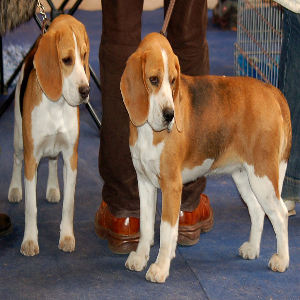

In [38]:
image = cv2.imread(PATH_TO_IMAGE)
image = cv2.resize(image, (300, 300))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
image_pil

In [39]:
coco_labels_length = len(coco_labels)
draw = ImageDraw.Draw(image_pil)
for box, score , label in zip(nms_boxes, nms_scores, nms_labels):
  if score> 0.5 and label > 0 and label < coco_labels_length:
    xmin = box[0]*300
    ymin = box[1]*300
    xmax = box[2]*300
    ymax = box[3]*300
    draw.rectangle((xmin, ymin, xmax, ymax), outline=(0, 0, 255), width=2)
    draw.text([xmin+2, ymin+2], text=coco_labels[label])

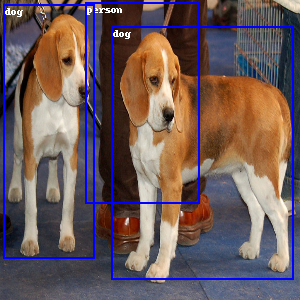

In [40]:
image_pil